# Part #03: Model Validation

## Step #01: Feature Selection REVISITED!

### Set up the workspace

In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, learning_curve, RandomizedSearchCV, validation_curve
from xgboost import XGBRegressor

In [2]:
# Read the results from before:
with open("./assets/preprocessing_results.pkl", mode="rb") as file_bin:
    resulst = pickle.load(file_bin)

In [3]:
# Unpack train and test sets:
feature_names, X_train, X_test, y_train, y_test = resulst.values()

### Perform backward feature elimination to exclude less important features

In [4]:
# Recreate the df for training & test sets:
X_train_df = pd.DataFrame(data=X_train, columns=feature_names)
X_test_df = pd.DataFrame(data=X_test, columns=feature_names)

In [5]:
# Instantiate a candidate model:
xgb_reg = XGBRegressor()

In [6]:
# Define a scoring function(s):
r2 = make_scorer(r2_score, greater_is_better=True)
rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

Validating current performance...
Validating current performance done in 0.17 minutes!

Validating longitude...
Validating longitude done in 0.13 minutes!

Validating latitude...
Validating latitude done in 0.12 minutes!

Validating housing_median_age...
Validating housing_median_age done in 0.13 minutes!

Validating total_rooms...
Validating total_rooms done in 0.13 minutes!

Validating population...
Validating population done in 0.13 minutes!

Validating median_income...
Validating median_income done in 0.10 minutes!

Validating ocean_proximity_1H OCEAN...
Validating ocean_proximity_1H OCEAN done in 0.13 minutes!

Validating ocean_proximity_INLAND...
Validating ocean_proximity_INLAND done in 0.13 minutes!

Validating ocean_proximity_NEAR BAY...
Validating ocean_proximity_NEAR BAY done in 0.13 minutes!

Validating ocean_proximity_NEAR OCEAN...
Validating ocean_proximity_NEAR OCEAN done in 0.13 minutes!

                             min  mean   max
ocean_proximity_NEAR OCEAN  0.82  0.8

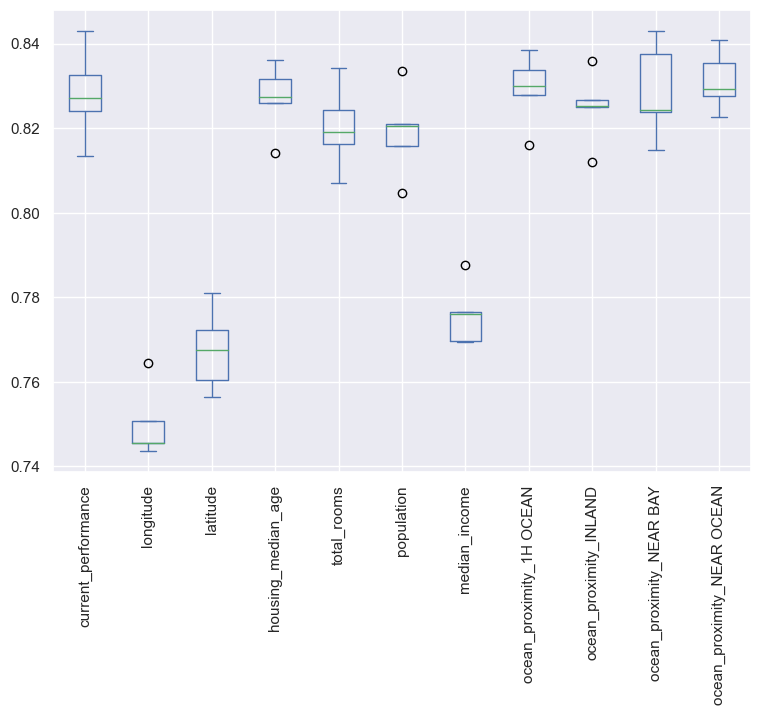

In [7]:
%%time
# Compare different features:
%run "./recipes/compare_features.py";
results = compare_features(xgb_reg, X_train_df, y_train, r2, cv=10);

In [8]:
# Determine irrelevant features:
n_features = 6
irrelevant_features = [f for f in results.index[:n_features] if f != "current_performance"]
irrelevant_features

['ocean_proximity_NEAR OCEAN',
 'ocean_proximity_1H OCEAN',
 'ocean_proximity_NEAR BAY',
 'housing_median_age',
 'ocean_proximity_INLAND']

In [9]:
# Drop irrelevant features:
X_train_df = X_train_df.drop(irrelevant_features, axis=1)

Validating current performance...
Validating current performance done in 0.13 minutes!

Validating longitude...
Validating longitude done in 0.10 minutes!

Validating latitude...
Validating latitude done in 0.10 minutes!

Validating total_rooms...
Validating total_rooms done in 0.10 minutes!

Validating population...
Validating population done in 0.10 minutes!

Validating median_income...
Validating median_income done in 0.08 minutes!

                      min  mean   max
current_performance  0.81  0.83  0.84
population           0.80  0.82  0.84
total_rooms          0.80  0.82  0.83
median_income        0.77  0.77  0.78
latitude             0.65  0.67  0.69
longitude            0.62  0.64  0.65


CPU times: total: 2min 37s
Wall time: 41.6 s


<Figure size 640x480 with 0 Axes>

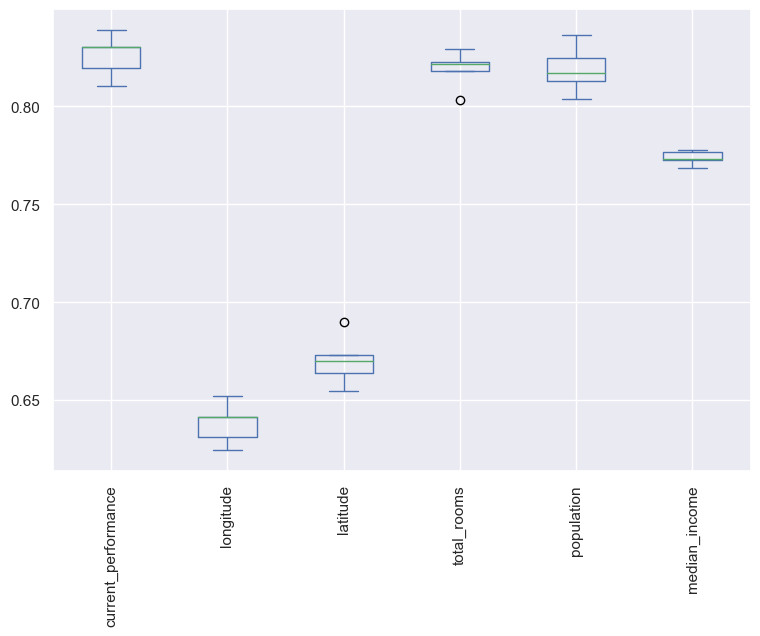

In [10]:
%%time
# Compare remaining features:
%run "./recipes/compare_features.py";
results = compare_features(xgb_reg, X_train_df, y_train, r2, cv=10);

In [11]:
# Drop irrelevant features from test set:
X_test_df = X_test_df.drop(irrelevant_features, axis=1)

In [12]:
# Convert train and test set into numpy arrays:
X_train = X_train_df.to_numpy(dtype=np.float32)
X_test = X_test_df.to_numpy(dtype=np.float32)

In [13]:
# Save feature names for later:
feature_names = X_train_df.columns.tolist()

## Step #02: Plotting the Learning Curve

In [14]:
%%time
# Perform CV on different sample sizes:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_reg,
    X_train,
    y_train,
    train_sizes=np.linspace(start=0.2, stop=1.0, num=5),
    cv=10,
    scoring=r2,
    random_state=42
)

CPU times: total: 3min 45s
Wall time: 1min 3s


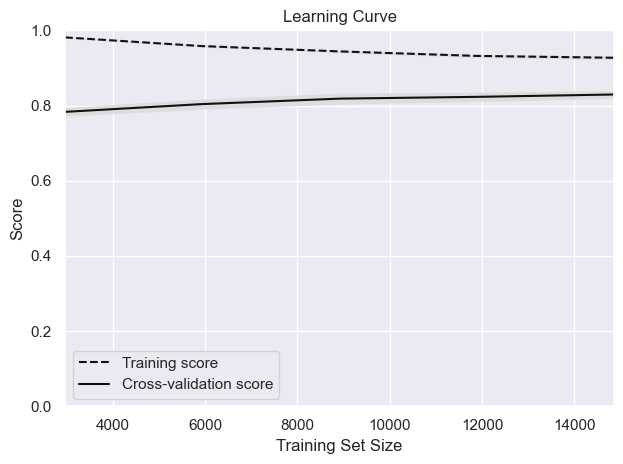

In [15]:
# Plot the learning curve:
%run "./recipes/plot_learning_curve.py"
plot_learning_curve(train_sizes, train_scores, test_scores);

## Step #03: Plotting the Validation Curve(s)

In [16]:
# Instantiate the model:
xgb_reg = XGBRegressor()

In [17]:
# Create range of values for the hyperparameter in question:
n_estimators = [int(x) for x in np.linspace(start=50, stop=300, num=6)]

In [18]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=n_estimators,
    cv=5,
    scoring=r2
)

CPU times: total: 5min 42s
Wall time: 1min 28s


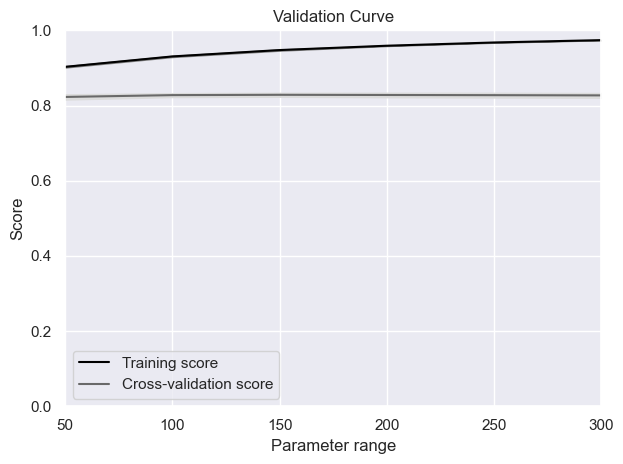

In [19]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(n_estimators, train_scores, test_scores)

In [20]:
best_n_estimators = n_estimators[test_scores.mean(axis=1).argmax()]
best_n_estimators

150

In [21]:
# Instantiate the model:
xgb_reg = XGBRegressor()

In [22]:
# Create range of values for the hyperparameter in question:
learning_rate = [x for x in np.linspace(start=0.1, stop=0.5, num=5)]

In [23]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="learning_rate",
    param_range=learning_rate,
    cv=5,
    scoring=r2
)

CPU times: total: 2min 51s
Wall time: 45 s


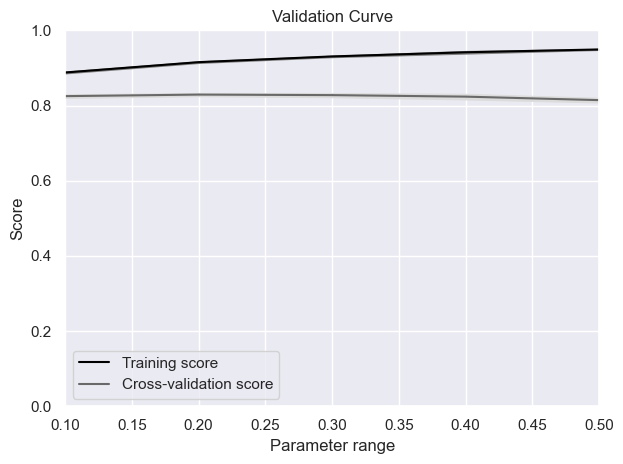

In [24]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(learning_rate, train_scores, test_scores)

In [25]:
best_learning_rate = learning_rate[test_scores.mean(axis=1).argmax()]
best_learning_rate

0.2

In [26]:
# Instantiate the model:
xgb_reg = XGBRegressor()

In [27]:
# Create range of values for the hyperparameter in question:
max_depth = [int(x) for x in np.linspace(start=2, stop=10, num=5)]

In [28]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="max_depth",
    param_range=max_depth,
    cv=5,
    scoring=r2
)

CPU times: total: 2min 52s
Wall time: 44.3 s


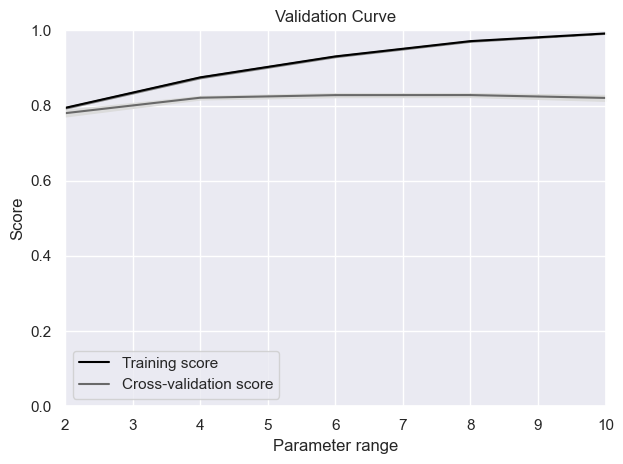

In [29]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(max_depth, train_scores, test_scores)

In [30]:
best_max_depth = max_depth[test_scores.mean(axis=1).argmax()]
best_max_depth

8

In [31]:
# Instantiate the model:
xgb_reg = XGBRegressor()

In [32]:
# Create range of values for the hyperparameter in question:
gamma = [x for x in np.linspace(start=0, stop=5, num=10)]

In [33]:
%%time
# Perform CV using different hyperparametr values:
train_scores, test_scores = validation_curve(
    xgb_reg,
    X_train,
    y_train,
    param_name="gamma",
    param_range=gamma,
    cv=5,
    scoring=r2
)

CPU times: total: 5min 16s
Wall time: 1min 26s


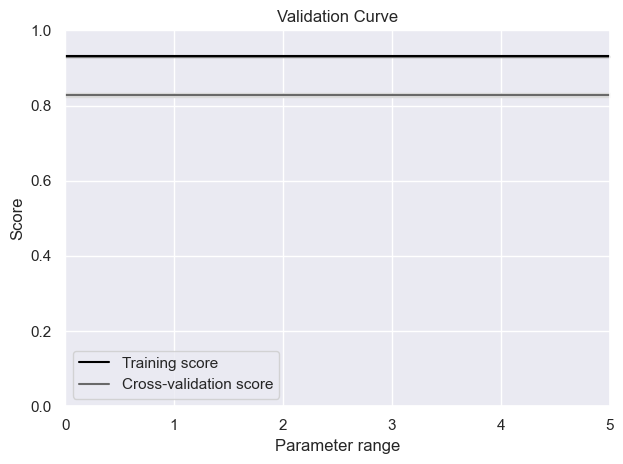

In [34]:
# Plot the validation curve:
%run "./recipes//plot_validation_curve.py"
plot_validation_curve(gamma, train_scores, test_scores)

In [35]:
best_gamma = gamma[test_scores.mean(axis=1).argmax()]
best_gamma

0.0

In [36]:
# Instantiate the model:
xgb_reg = XGBRegressor()

In [37]:
# Instantiate the best model:
best_xgb_reg = XGBRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    gamma=best_gamma);

Validating xgb_reg...
Validating xgb_reg done in 0.13 minutes!

Validating best_xgb_reg...
Validating best_xgb_reg done in 0.28 minutes!

               min  mean   max
xgb_reg       0.81  0.83  0.84
best_xgb_reg  0.81  0.83  0.84




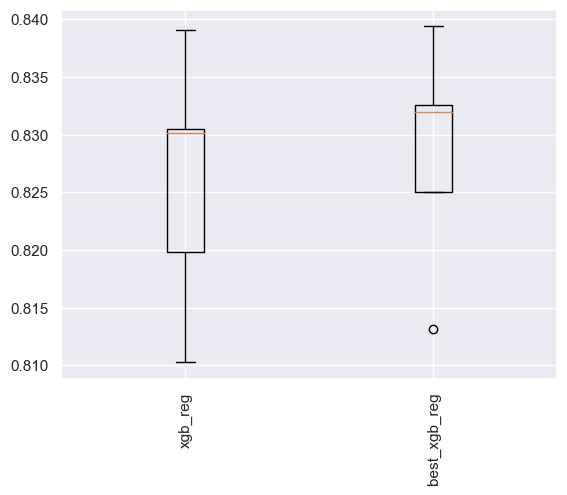

CPU times: total: 1min 35s
Wall time: 26.4 s


In [38]:
%%time
# Compare different models:
%run "./recipes/compare_models.py";
results = compare_models(
    X_train,
    y_train,
    r2,
    cv=10,
    xgb_reg=xgb_reg,
    best_xgb_reg=best_xgb_reg
);

## Step #04: Tuning the Model Hyperparameters

### Perform a randomized search over a pre-defined hyperparameter distribution

In [39]:
# Instantiate the model:
xgb_reg = XGBRegressor()

In [40]:
param_distributions = {
    "n_estimators": n_estimators,
    "learning_rate": learning_rate,
    "max_depth": max_depth,
    "gamma": gamma
}

In [41]:
# Perform a randomized search over the pre-determined param_distributions:
rand_cv_results = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=r2,
    cv=3,
    random_state=42
)

In [42]:
%%time
# Fit the RandomSearchCV object:
rand_cv_results.fit(X_train, y_train);

CPU times: total: 41min 3s
Wall time: 11min 1s


In [43]:
# Print the best parameters:
rand_cv_best_params = rand_cv_results.best_params_
print(rand_cv_best_params)

{'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 1.1111111111111112}


In [44]:
# Train the model with the best parameters:
best_rand__xgb_reg = XGBRegressor(**rand_cv_best_params)
best_rand__xgb_reg.fit(X_train, y_train);

In [45]:
# Evaluate the model:
score = best_rand__xgb_reg.score(X_test, y_test)
print(score)

0.8388927385328329


### Perform an optimized search over a pre-defined hyperparameter distribution

In [46]:
# Set optuna log level to WARNINGonly:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [47]:
# Define the objective function:
def objective(trial):
    
    # Define the hyperparameters:
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    # Train the model with CV:
    xgb_reg = XGBRegressor(**params)
    cv_results = cross_val_score(xgb_reg, X_train, y_train, scoring=r2, cv=3)

    # Evaluate the model
    r2_score = cv_results.mean()

    return r2_score

In [48]:
# Create a study:
study = optuna.create_study(direction='maximize');

In [49]:
%%time
# Run the study:
study.optimize(objective, n_trials=50)

CPU times: total: 50min 25s
Wall time: 14min 6s


In [50]:
# Print the best parameters:
optim_cv_best_params = study.best_params
print(optim_cv_best_params)

{'max_depth': 10, 'learning_rate': 0.05690547473484235, 'n_estimators': 322, 'min_child_weight': 9, 'gamma': 0.796402331034732, 'subsample': 0.7785148994501871, 'colsample_bytree': 0.9144368690875639, 'reg_alpha': 0.05790480062049659, 'reg_lambda': 0.35393017701001256}


In [51]:
# Train the model with the best parameters:
optimized_xgb_reg = XGBRegressor(**optim_cv_best_params)
optimized_xgb_reg.fit(X_train, y_train);

In [52]:
# Evaluate the model:
score = optimized_xgb_reg.score(X_test, y_test)
print(score)

0.8486317823289697


## Step #05: Final Model Evaluation

In [53]:
# Instantiate the best model so far:
best_model_so_far = XGBRegressor(**optim_cv_best_params)

In [54]:
# Fit the model:
best_model_so_far.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9144368690875639, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.796402331034732, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05690547473484235, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             n_estimators=322, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [55]:
# Evaluate the model using r2:
best_r2_score = r2(best_model_so_far, X_test, y_test)
print(f"R-squared = {best_r2_score:.2%}")

R-squared = 84.86%


In [56]:
# Evaluate the model using rmse:
best_rmse_score = rmse(best_model_so_far, X_test, y_test)

## Step #05: Saving Results

In [57]:
# Create a dictionary to hold the results:
feature_elimination_results = {
    "feature_names": feature_names,
    "X_train": X_train.astype(np.float32),
    "X_test": X_test.astype(np.float32),
    "y_train": y_train.astype(np.float32),
    "y_test": y_test.astype(np.float32)
}

In [58]:
# Pickle the results:
with open("./assets/feature_elimination_results.pkl", mode="wb") as file_bin:
    pickle.dump(feature_elimination_results, file_bin)

In [59]:
# Save the model:
best_model_so_far.save_model("./assets/best_model_so_far.json")

In [60]:
# Load the saved model:
saved_model = XGBRegressor()
saved_model.load_model("./assets/best_model_so_far.json");